# Домашнее задание №2 - Линейные модели. Градиентный спуск

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.linear_model import SGDRegressor
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [250]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [251]:
def f(w):
    
    return np.sum(np.sin(w)**2)

# Задание 1. Градиентный спуск для функции f

In [252]:
def grad_f(w): 
    return np.sin(2*w)

In [253]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [254]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

In [255]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

C:\Users\asyan\AppData\Local\Temp/ipykernel_9468/1727858522.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


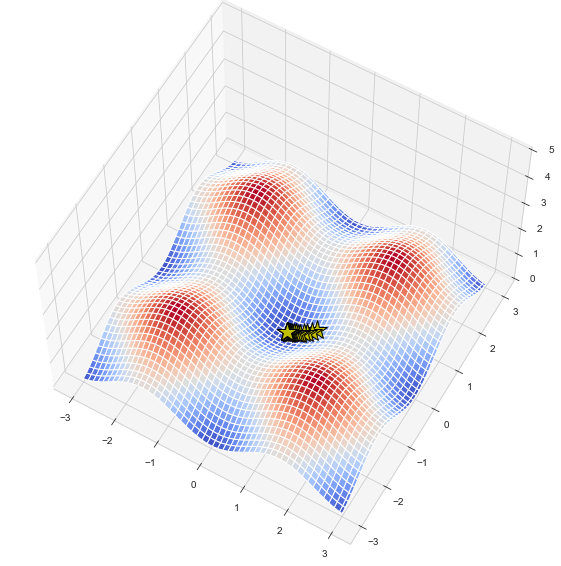

In [256]:
steps = gradient_desc_vis(f, grad_f)

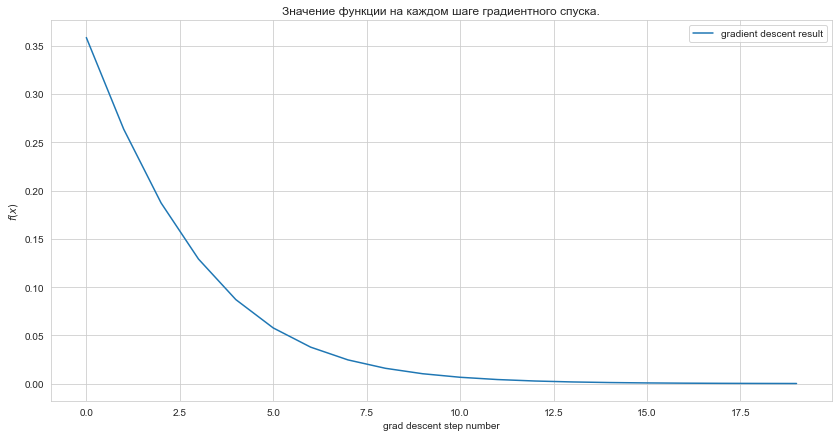

In [257]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге градиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

# Задание 2. Реализация линейной регресии

Задание 2.1. MSE и ее градиент

In [315]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    N = y_true.shape[0]
    return 1/N * ((y_true - y_pred).T)*(y_true - y_pred)



def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    N = y_true.shape[0]
    return 2/N * (np.dot(X.T, (y_pred - y_true)))
    

class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

In [316]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

In [317]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

Задание 2.2. Предсказания линейной регрессии 

In [318]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return np.dot(X_test, self.W)

    
    
    def __repr__(self):
        return "My custom linear regression"

In [319]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

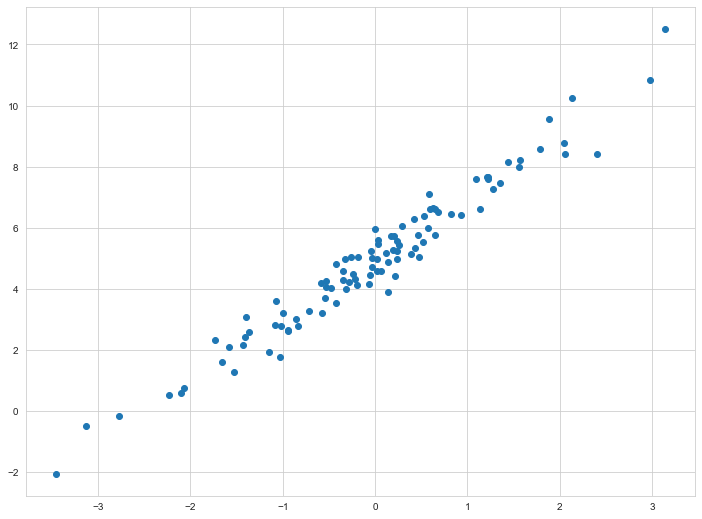

In [320]:
plt.scatter(X, y);

In [321]:
custom_lin_reg = CustomLinearRegression()

In [322]:
custom_lin_reg.fit(X, y)

My custom linear regression

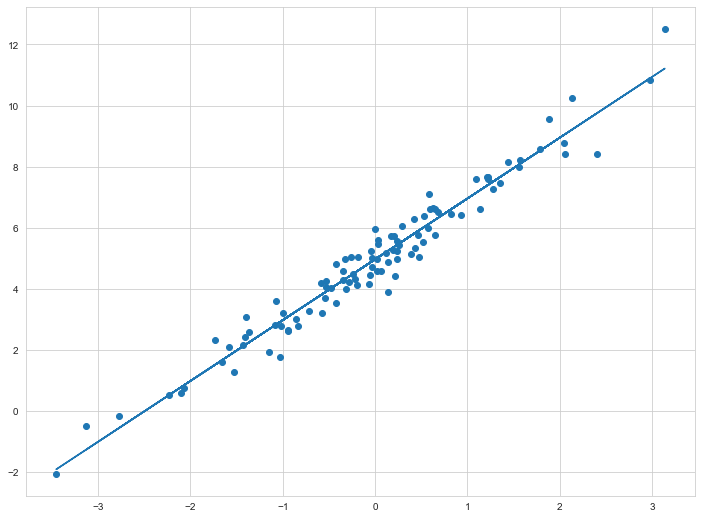

In [323]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

# 2.3 Используем встроенную линейную регрессию

In [177]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

In [178]:
scaler = StandardScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)

In [182]:
regression_model = LinearRegression()

linear_regression_model = SGDRegressor(tol=.0001, eta0=.01) 
linear_regression_model.fit(scaled_data, y)
predictions = linear_regression_model.predict(scaled_data)
mse = mean_squared_error(y, predictions) 
print("MSE: ", mse)
mae = mean_absolute_error(y, predictions)
print("MAE: ", mae)

r2 = r2_score(y, predictions)

print('R2 score: ', r2)

MSE:  21.96340221700113
MAE:  3.2675391542567396
R2 score:  0.7398303992931259


In [135]:
linear_regression_model.fit(scaled_data, y) 
sorted(list(zip(feature_names, linear_regression_model.coef_)), 
       key=lambda x: abs(x[1]))

[('AGE', -0.016387520425181712),
 ('INDUS', -0.15095067189434427),
 ('CHAS', 0.7038963172593244),
 ('CRIM', -0.8221876821541511),
 ('B', 0.8233076284002133),
 ('ZN', 0.8928285169683904),
 ('TAX', -1.1250845195093948),
 ('NOX', -1.798583174409679),
 ('RAD', 1.8142166902628765),
 ('PTRATIO', -1.9656862583638899),
 ('RM', 2.6973297906873714),
 ('DIS', -3.015119160660113),
 ('LSTAT', -3.6392968676326993)]

Наибольшее влияние оказывают LSTAT - % населения с низким социальным статусом, DIS - расстояния до пяти центров занятости Бостона, RM -  среднее количество комнат в квартире.

# 3 Реализация логистической регрессии

In [343]:
def sigmoid(output):
    return 1 / (1 + np.exp(-output))

In [344]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    return -(y_true * np.log(sigmoid(y_pred)) + (1-y_true) * np.log(1-sigmoid(y_pred)))

    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.dot(X.T, (sigmoid(y_pred) - y_true))



class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

In [355]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return (np.exp(np.dot(X_test, self.W)))/(1+np.exp(np.dot(X_test, self.W)))
    
    
    def __repr__(self):
        return "My custom logistic regression"

MSE:  0.0689364025241857
MAE:  0.06980233113929109


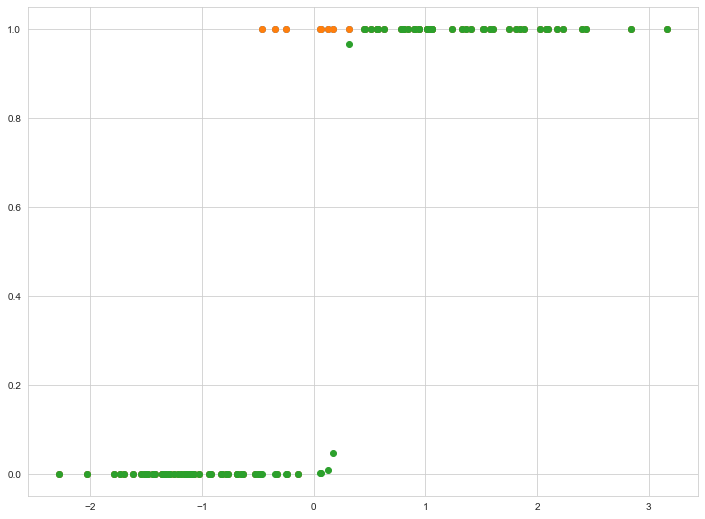

In [356]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)
plt.scatter(X, y);
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred);

mse = mean_squared_error(y, y_pred) 
print("MSE: ", mse)
mae = mean_absolute_error(y, y_pred)
print("MAE: ", mae)

# Задание 3.4. Применение логистической регрессии

In [239]:
pokemon = pd.read_csv("Pokemon.csv")

In [240]:
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [241]:
pokemon = pd.read_csv("Pokemon.csv")
y = (pokemon["Legendary"].astype(int))
del pokemon["#"], pokemon["Name"], pokemon["Type 1"], pokemon["Type 2"], pokemon["Generation"], pokemon["Legendary"]
X = pokemon

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print(X)

[[-0.97676549 -0.95062622 -0.92490618 ... -0.2391303  -0.24818854
  -0.80150318]
 [-0.25108843 -0.3628221  -0.5241302  ...  0.21955954  0.29115635
  -0.28501525]
 [ 0.74984544  0.42091674  0.09244823 ...  0.83114599  1.01028289
   0.40363531]
 ...
 [ 1.37542912  0.42091674  0.95565803 ...  2.36011211  2.08897269
   0.05931003]
 [ 2.04271837  0.42091674  2.49710411 ...  2.97169856  2.08897269
   0.40363531]
 [ 1.37542912  0.42091674  0.95565803 ...  1.74852566  0.65071962
   0.05931003]]


In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=3)

In [243]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [244]:
clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

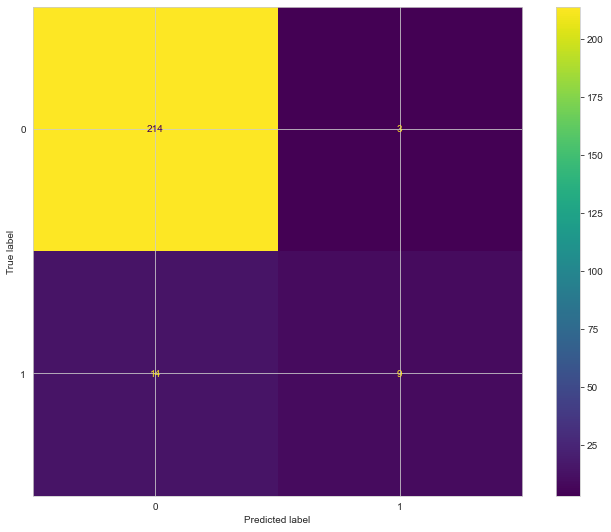

In [245]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

SVC(random_state=0)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

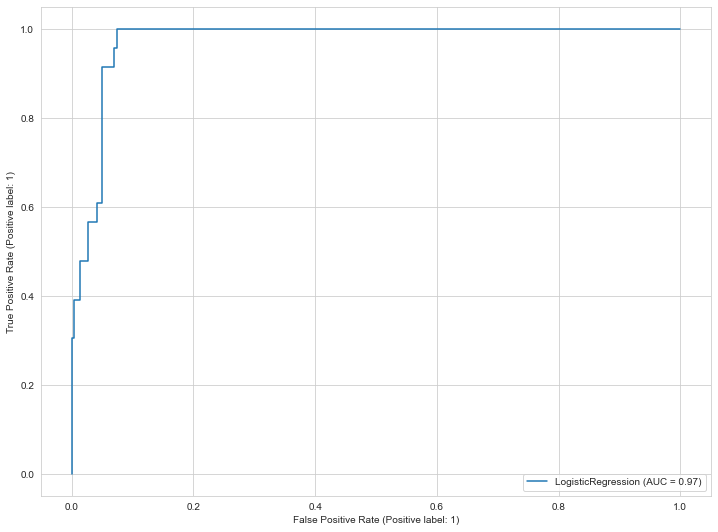

In [246]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import datasets, metrics, model_selection, svm

metrics.plot_roc_curve(clf, X_test, y_test) 
plt.show()

In [247]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y, clf.predict_proba(X)[:, 1]) #ну и на графике тоже в углу подписано, т.е. точность классификатора высокая 

0.9740345368916798

Feature:  0 importance:  0.972913734017748
Feature:  1 importance:  0.519384256505972
Feature:  2 importance:  0.26435462529658194
Feature:  3 importance:  0.7265056055784445
Feature:  4 importance:  0.8196580703822085
Feature:  5 importance:  0.57173557234567
Feature:  6 importance:  1.0145831689042086


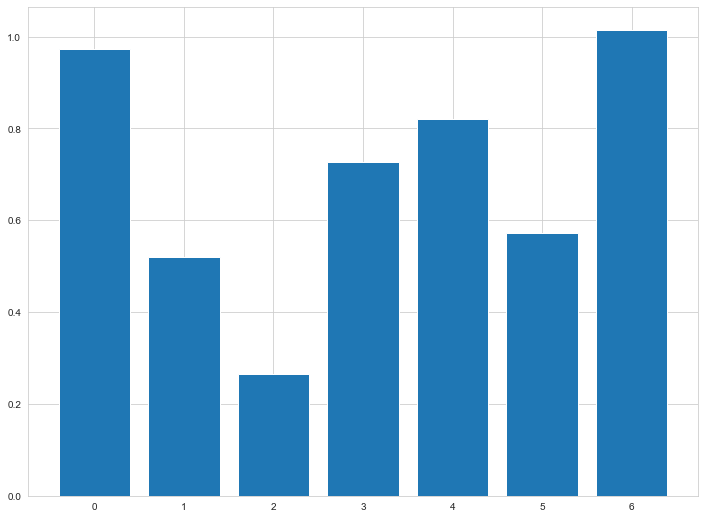

In [248]:
importance = clf.coef_[0]
for i,v in enumerate(importance):
    print("Feature: ", i, "importance: ", v)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Т.е. наибольшее значение имели скорость (speed), сумма показателей (total) и сила специальной атаки покемона (sp. atk).

# Задание 4 (музыкальное)

Один из любимых исполнителей в последнее время - Николай Гринько. У него есть абсолютно потрясающая песня "Сурикаты", и не менее классные "Божья коровка", "Однокомнатная планета", "Паспорт, билет и ручная кладь".